# Face Aging Using Conditional GAN with PyTorch

In [0]:
# Download faces only
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

In [0]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Prepare Data

In [0]:
def calc_age(taken, dob):
    '''
    Calculate age
    :param taken: Date when photo taken
    :param dob: Date of birth in serials
    :return: age in years
    '''
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    # assume the photo was taken in the middle of the year
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [0]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):
    '''
    Load meta data and calculate age
    :param dataset: dataset name, defaults = 'wiki'
    :param data_dir: data directory, defaults = './wiki_crop'
    :return: list of full_path and age
    '''
    # Load meta data
    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    # Load all file paths
    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]

    # Load dates of birth
    dob = meta_data['dob'][0]

    # Load years when photo taken
    photo_taken = meta_data['photo_taken'][0]

    # Calculate age
    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]
    
    # Clean mapping with age > 0
    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
    
    # List of full_path, age
    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
# helper one-hot function
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):
    '''
    Convert tensor x to one-hot tensor
    '''
    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

# Data Loader

In [0]:
class ImageAgeDataset(Dataset):
    '''Image and corresponding age Dataset'''
    def __init__(self, dataset, data_dir, transform=None):
        '''
        :param dataset: Dataset name.
        :param data_dir: Directory with all the images.
        :param transform: Optional transform to be applied on sample
        '''
        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [0]:
class Resize(object):
    '''Resize the input PIL Image to the given size.'''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        # expand dept from 1 to 3 channels for gray images
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [0]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 128
#num_workers = 0

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

# build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [0]:
iter(train_loader).next()

{'age': tensor([ 28,  39,  59,  31,  41,  51,  33,  77,  60,  29,  41,  36,  23,  28,
          38,  25,  32,  36,  19,  77,  51,  42,  30,  33,  28,  33,  29,  59,
          13,  27,  60,  41,  30,  68,  24,  24,  49,  45,  24,  33,  72,  31,
          52,  51,  47,  56,  34,  55,  22,  30,  47,  32,  57,  53,  53,  54,
          46,  33,  46,  28,  42,  67,  78,  49,  22,  32,  26,  31,  48,  43,
          46,  25,  62,  30, 101,  28,  31,  24,  45,  61,  27,  32,  37,  52,
          26,  35,  30,  29,  26,  29,  23,  66,  63,  57,  72,  49,  53,  27,
          26,  70,  17,  25,  39,  26,  21,  39,  31,  40,  28,  26,  58,  23,
          24,  27,  58,  29,  65,  45,  38,  21,  28,  70,  49,  63,  36,  42,
          30,  37]),
 'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2941, 0.3373],
           [1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2980, 0.3412],
           [1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2980, 0.3451],
           ...,
           [0.0902, 0.0784, 0.0941,

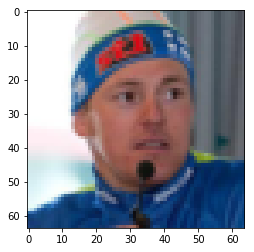

In [0]:
plt.imshow(train_dataset[0]['image'].numpy().transpose(1,2,0))

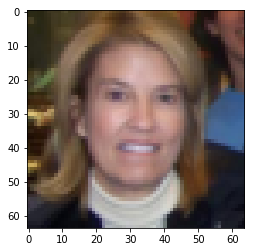

In [0]:
plt.imshow(train_dataset[60941]['image'].numpy().transpose(1,2,0))

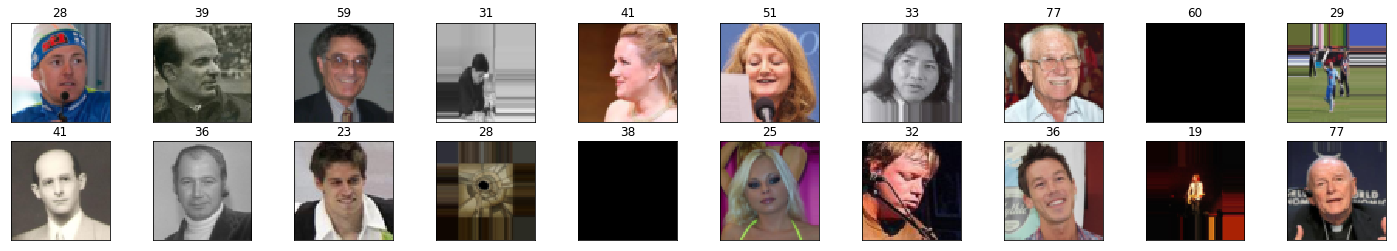

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
data = dataiter.next()
images, labels = data['image'], data['age']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Define Models

## Discriminator

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Helpers
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)
        
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, y_size, conv_dim=64):
        '''
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        :param y_size: The number of conditions 
        '''
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.y_size = y_size
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)
            
    def forward(self, x, y):
        '''
        Forward propagation of the neural network
        :param x: The input scaled image x
        :param y: One-hot encoding condition tensor y (N,y_size)
        :return: Discriminator logits; the output of the neural network
        '''
        x = F.relu(self.conv1(x))
        y = y.view(-1,y.size()[-1],1,1)
        y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generator

In [0]:
# Helpers
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers = []
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    
    def __init__(self, z_size, y_size, conv_dim=64):
        '''
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        '''
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # self.fc = nn.Linear(z_size+y_size, conv_dim*8*4*4)
        self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, z, y):
        '''
        Forward propagation of the neural network
        :param x: The input to the neural network
        :param y: The input condition to the neural network, Tensor (N,y_size)
        :return: A 64x64x3 Tensor image as output
        '''
        x = torch.cat([z, y], dim=1)
        x = x.view(-1, x.size()[-1], 1, 1)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = self.t_conv5(x)
        x = torch.tanh(x)
        
        return x

## Build complete network

In [0]:
# define hyperparams
conv_dim = 64
z_size = 100
y_size = 6 # no. of age classes

# define discriminator and generator
D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05,

## Discriminator and Generator Losses

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    labels = labels.to(device)
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [0]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [0]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]
    
    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [0]:
%%time

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)

# move models to GPU, if available
G.to(device)
D.to(device)

import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

# train the network
for epoch in range(num_epochs):
    
    for batch_i, batch in enumerate(train_loader):
                
        batch_size = batch['image'].size(0)
        
        # important rescaling image step
        real_images = scale(batch['image'])
        
        # one-hot age
        ages = one_hot(batch['age'], bins)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        
        # Compute the discriminator losses on real images
        real_images = real_images.to(device)
        ages = ages.to(device)
        
        D_real = D(real_images, ages)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        z = z.to(device)
        #if train_on_gpu:
        #    z = z.cuda()
        fake_images = G(z, ages)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images, ages)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images, ages)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    fixed_z = fixed_z.to(device)
    fixed_y = fixed_y.to(device)
    samples_z = G(fixed_z, fixed_y)
    samples.append(samples_z)
    G.train() # back to training mode
    
    # Save checkpoint
    checkpoint(G, D, epoch, model, root_dir)

# Save training generator samples
save_samples_ages(samples, fixed_y, model, root_dir)


Epoch [    1/   50] | d_loss: 1.4138 | g_loss: 0.8720
Epoch [    1/   50] | d_loss: 0.6222 | g_loss: 2.1453
Epoch [    2/   50] | d_loss: 0.7061 | g_loss: 2.7619
Epoch [    2/   50] | d_loss: 0.6482 | g_loss: 1.9393
Epoch [    3/   50] | d_loss: 0.8552 | g_loss: 3.2015
Epoch [    3/   50] | d_loss: 1.0621 | g_loss: 4.0378
Epoch [    4/   50] | d_loss: 0.6399 | g_loss: 3.2872
Epoch [    4/   50] | d_loss: 0.9088 | g_loss: 3.4324
Epoch [    5/   50] | d_loss: 0.4950 | g_loss: 2.5613
Epoch [    5/   50] | d_loss: 0.8391 | g_loss: 4.3586
Epoch [    6/   50] | d_loss: 0.4257 | g_loss: 2.5692
Epoch [    6/   50] | d_loss: 0.3501 | g_loss: 4.0121
Epoch [    7/   50] | d_loss: 0.6852 | g_loss: 3.8477
Epoch [    7/   50] | d_loss: 0.2103 | g_loss: 2.8692
Epoch [    8/   50] | d_loss: 0.5282 | g_loss: 2.2365
Epoch [    8/   50] | d_loss: 0.2398 | g_loss: 3.2290
Epoch [    9/   50] | d_loss: 0.3392 | g_loss: 2.0968
Epoch [    9/   50] | d_loss: 0.4380 | g_loss: 4.1566
Epoch [   10/   50] | d_loss

## Training loss

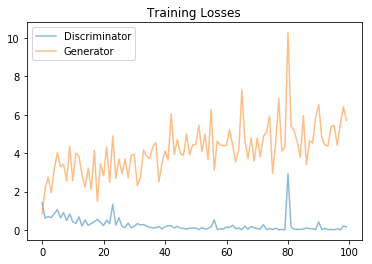

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, ages):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img, age in zip(axes.flatten(), samples[epoch], ages):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(age)
        im = ax.imshow(img.reshape((64,64,3)))

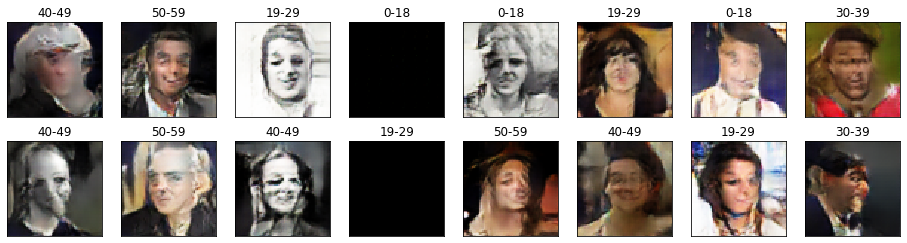

In [0]:
fixed_y_ages = oh_to_class(fixed_y)
_ = view_samples(-1, samples, fixed_y_ages)